In [18]:
import joblib
import os
import tensorflow as tf
import keras
import numpy as np

from keras.utils import pad_sequences

In [19]:
from text_prep import load_dataset, load_descriptions, clean_descriptions, to_vocabulary


In [20]:
# captions = clean_descriptions(load_descriptions(path))

In [21]:
train_path = 'data/Flickr8k_text/Flickr_8k.trainImages.txt'
test_path = 'data/Flickr8k_text/Flickr_8k.testImages.txt'

In [22]:
train_dataset = load_dataset(train_path)
test_dataset = load_dataset(test_path)

In [23]:
captions = joblib.load('captions.pkl')

In [24]:
features = joblib.load('features.pkl')

In [25]:
def load_feat_descr(dict, dataset):
    return {k: dict[k] for k in dataset}

In [26]:
captions_train = load_feat_descr(captions, train_dataset)
features_train = load_feat_descr(features, train_dataset)
captions_test = load_feat_descr(captions, test_dataset)
features_test = load_feat_descr(features, test_dataset)

In [30]:
# vocab = to_vocabulary(captions_train)
# joblib.dump(vocab, 'vocabulary.pkl')

vocab = joblib.load('vocabulary.pkl')

In [31]:
vc = keras.layers.TextVectorization(
    vocabulary = ['startseq'] + vocab + ['endseq']
)

In [32]:
max_len = 0
for key in captions_train.keys():
    for d in captions_train[key]:
        max_len = max(max_len, len(d))
max_len        

36

## Preparing generator for model

In [33]:
def sequencer(dataset, captions, features):
    X_1, X_2, y = [], [], []
    for key in dataset:
        for desc in captions[key]:
            seq = ['startseq'] + desc + ['endseq']
            seq = vc(seq)
            for i in range(1, len(seq)):
                X_1.append(features[key][0])
                X_2.append(seq[:i])
                y.append(seq[i])
    X_2 = pad_sequences(X_2, maxlen=max_len+2)
    return np.array(X_1), X_2.reshape((X_2.shape[0],X_2.shape[1])), np.array(y)

In [34]:
def generate_seq(dataset, captions, features):

    while True:
        for key in dataset:
            X_1, X_2, y = sequencer([key], captions, features)
            yield [X_1, X_2], y

In [35]:
generator = generate_seq(train_dataset[:2], captions, features)
inputs, outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

(50, 1000)
(50, 38)
(50, 1)


# The model

In [36]:
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, add
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [37]:
inputs_fe = Input(shape=(1000,))
fe1 = Dropout(0.5)(inputs_fe)
fe2 = Dense(256, activation='relu')(fe1)

inputs_se = Input(shape=(max_len+2,))
se1 = Embedding(len(vocab)+2, 256, mask_zero=True)(inputs_se)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256, activation='tanh')(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(len(vocab)+4, activation='softmax')(decoder2)

model = Model(inputs=[inputs_fe, inputs_se], outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 38, 256)      1421312     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 1000)         0           ['input_1[0][0]']                
                                                                                              

## Training with full data loaded

In [36]:
# filepath = './models/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [28]:
# X_1_train, X_2_train, y_train = sequencer(train_dataset[:10], captions, features)
# X_1_test, X_2_test, y_test = sequencer(test_dataset[:10], captions, features)

In [29]:
# model.fit(
#     [X_1_train, X_2_train], 
#     y_train, 
#     epochs=1,
#     callbacks=[checkpoint], 
#     validation_data=([X_1_test, X_2_test], y_test)
#     )

20/20 [==============================] - ETA: 0s - loss: 8.0789
Epoch 1: val_loss improved from inf to 6.43182, saving model to ./models\model-ep001-loss8.079-val_loss6.432.h5
20/20 [==============================] - 10s 339ms/step - loss: 8.0789 - val_loss: 6.4318


## Training with generator

In [39]:
generator = generate_seq(train_dataset, captions_train, features_train)
generator_val = generate_seq(test_dataset, captions_test, features_test)

val_loss_list = []
steps = len(train_dataset)
steps_val = len(test_dataset)

In [95]:
epochs=4

for i in range(epochs):
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    val_loss = model.evaluate(generator_val, steps= steps_val, verbose=1)
    val_loss_list.append(val_loss)
    if val_loss == min(val_loss_list):
        model.save('./models/model_' + str(val_loss) + '.h5')

1000/1000 [==============================] - 143s 143ms/step - loss: 3.3063


# Evaluation

In [41]:
from keras.utils import load_img
directory = 'data/Flicker8k_Dataset'

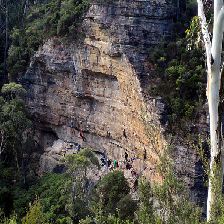

In [99]:
name = train_dataset[100]
image = features[name]
picture = load_img(directory + '/' + name + '.jpg', target_size=(224,224))
picture

In [43]:
from model import RnnModel

In [96]:
model_path = 'models\model_3.288113594055176.h5'
from keras.models import load_model

rnn = RnnModel(load_model(model_path), vocab, max_len)

In [100]:
pred = rnn.predict(image)[1:]
pred

['a', 'man', 'be', 'climb', 'up', 'a', 'rock']

In [101]:
from nltk.translate.bleu_score import corpus_bleu

In [102]:
path = 'data\Flickr8k_text\Flickr_8k.devImages.txt'
dataset_f = load_dataset(path)
len(dataset_f)

1000

In [103]:
references = []
predictions = []
for name in dataset_f:
    references.append(captions[name])
    predictions.append(rnn.predict(features[name])[1:])


In [104]:
print('BLEU-1', corpus_bleu(references, predictions, weights=(1.0, 0.0, 0.0, 0.0)))
print('BLEU-2', corpus_bleu(references, predictions, weights=(0.5, 0.5, 0.0, 0.0)))
print('BLEU-2', corpus_bleu(references, predictions, weights=(0.3, 0.3, 0.3, 0.0)))
print('BLEU-2', corpus_bleu(references, predictions, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1 0.4782608695652174
BLEU-2 0.29155262027124396
BLEU-2 0.19433222296490027
BLEU-2 0.09500593414212126


Secretary problem

In [267]:
def max_finder(k, n):
    a = [i for i in range(n)]
    np.random.shuffle(a)
    pre_max = max(a[:k])
    for i in a[k:]:
        if i>pre_max:
            return i
    return -1


In [301]:
succes_list = []
for k in range(100):
    succes = 0
    for i in range(10000):
        if max_finder(k+1,100) in [99]:
            succes += 1
    succes_list.append(succes)
succes_list.index(max(succes_list))

35

In [290]:
100/np.e

36.787944117144235

In [292]:
import matplotlib.pyplot as plt

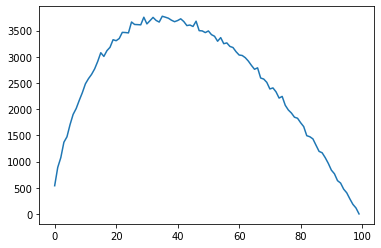

In [302]:
plt.plot(succes_list)

In [303]:
succes_list[35]

3773